# Trabajo Practico N° 3
**Materia:** Minería de datos

**Año:** 2025

**Integrantes:** Juana Chies Doumecq, Nicolas Mancini

In [104]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from feature_engine.outliers import Winsorizer 

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_curve, auc, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score,
                             ConfusionMatrixDisplay, classification_report)

In [105]:
dataset = pd.read_csv('dxWeather.csv')

In [106]:
#Creamos copia del dataset original
df = dataset.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         10090 non-null  int64  
 1   Humedad             10090 non-null  int64  
 2   VientoVelocidad     10090 non-null  float64
 3   Precipitation       10090 non-null  int64  
 4   PresionAtmosferica  10090 non-null  float64
 5   Localizacion        10090 non-null  object 
 6   TipoClima           10090 non-null  object 
 7   Estacion            10090 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 630.8+ KB


In [107]:
df.head()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno


In [108]:
df.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000
mean,21.872349,67.195045,9.634936,50.796333,1007.685836
std,16.426722,20.463797,6.795890,32.333798,38.763971
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,55.000000,5.000000,18.000000,998.570000
50%,23.000000,69.000000,8.500000,53.000000,1010.315000
75%,32.000000,81.000000,13.500000,80.000000,1017.820000
max,109.000000,109.000000,47.500000,109.000000,1199.210000


## Análisis exploratorio de datos

**Análisis del balanceo del dataset**

In [109]:
conteo = df['Estacion'].value_counts()

df_balanceo = pd.DataFrame({
    'Conteo': conteo,
    'Frecuencia de aparición': conteo / conteo.sum() * 100
})

df_balanceo

,Conteo,Frecuencia de aparición
Estacion,,
Primavera,2598,25.748266
Invierno,2500,24.777007
Otonio,2500,24.777007
Verano,2492,24.697721


esta balanceado

**Valores duplicados**

In [110]:
df.duplicated().values.any()

np.False_

**Valores faltantes**

In [111]:
df.isna().sum()

Temperatura           0
Humedad               0
VientoVelocidad       0
Precipitation         0
PresionAtmosferica    0
Localizacion          0
TipoClima             0
Estacion              0
dtype: int64

**Codificación de variables categóricas**

In [112]:
# Convertir columnas categóricas en numéricas
df = pd.get_dummies(data=df, columns=['Localizacion', 'TipoClima'])

cols_bool = ['Localizacion_Costa', 'Localizacion_Llanura', 'Localizacion_Montania', 'TipoClima_Lluvioso',
       'TipoClima_Nevado', 'TipoClima_Nublado', 'TipoClima_Soleado']
df[cols_bool] = df[cols_bool].astype('int')

df.head()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Estacion,Localizacion_Costa,Localizacion_Llanura,Localizacion_Montania,TipoClima_Lluvioso,TipoClima_Nevado,TipoClima_Nublado,TipoClima_Soleado
0,39,96,8.5,71,1011.43,Primavera,0,1,0,0,0,1,0
1,30,64,7.0,16,1018.72,Primavera,0,0,1,0,0,0,1
2,38,83,1.5,82,1026.25,Primavera,1,0,0,0,0,0,1
3,32,55,3.5,26,1010.03,Verano,0,1,0,0,0,1,0
4,3,85,6.0,96,984.46,Invierno,0,1,0,0,1,0,0


**Distribuciones  y correlaciones de las variables**

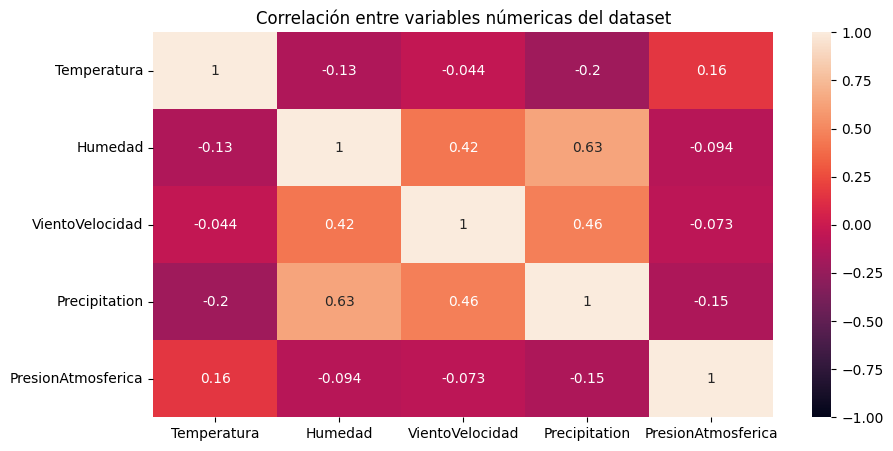

In [113]:
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

plt.figure(figsize=(10,5))
sns.heatmap(df[columnas_numericas].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

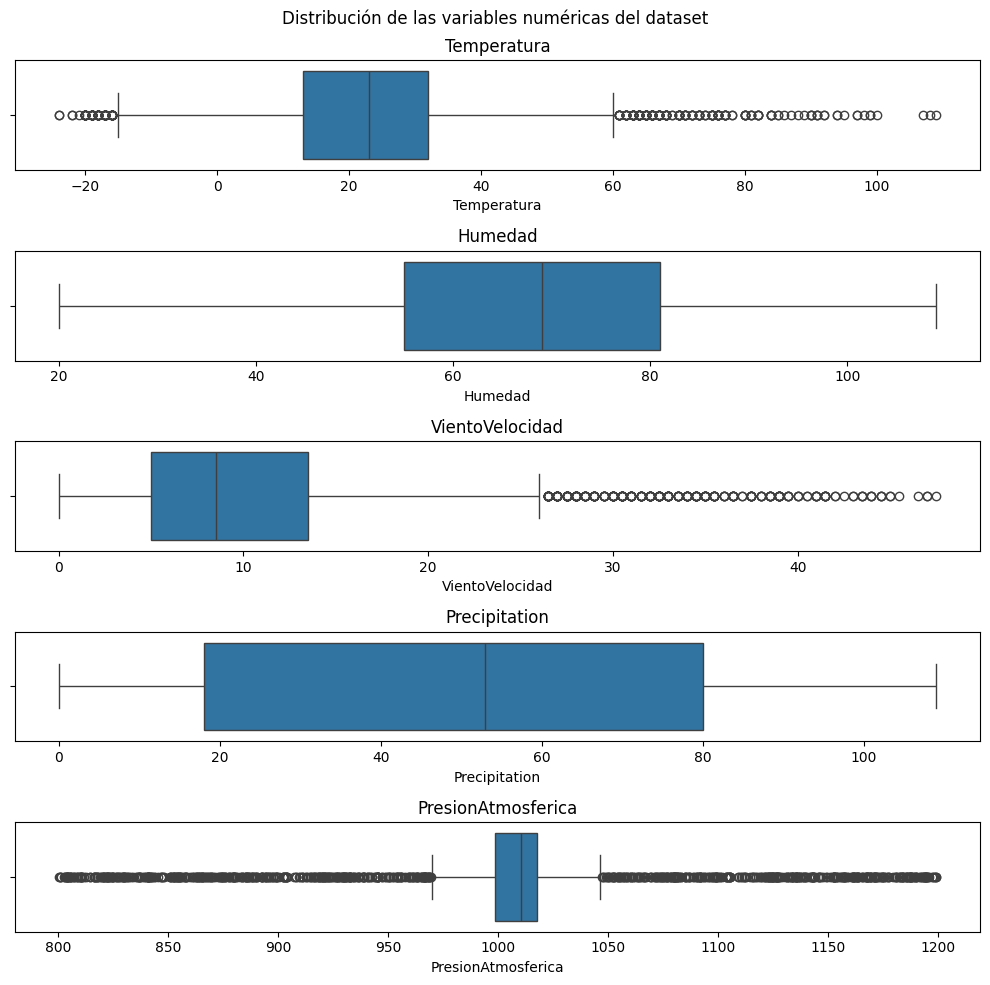

In [114]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=df[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset')
plt.tight_layout()
plt.show()

**Outliers**

In [115]:
# Temperatura: valores válidos hasta 50°C
df = df[df['Temperatura'] <= 50]

# Humedad: valores válidos hasta 100%
df = df[df['Humedad'] <= 100]

# Presión atmosférica: usando IQR para outliers
Q1 = df['PresionAtmosferica'].quantile(0.25)
Q3 = df['PresionAtmosferica'].quantile(0.75)
IQR = Q3 - Q1

lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

df = df[(df['PresionAtmosferica'] >= lim_inf) & (df['PresionAtmosferica'] <= lim_sup)]


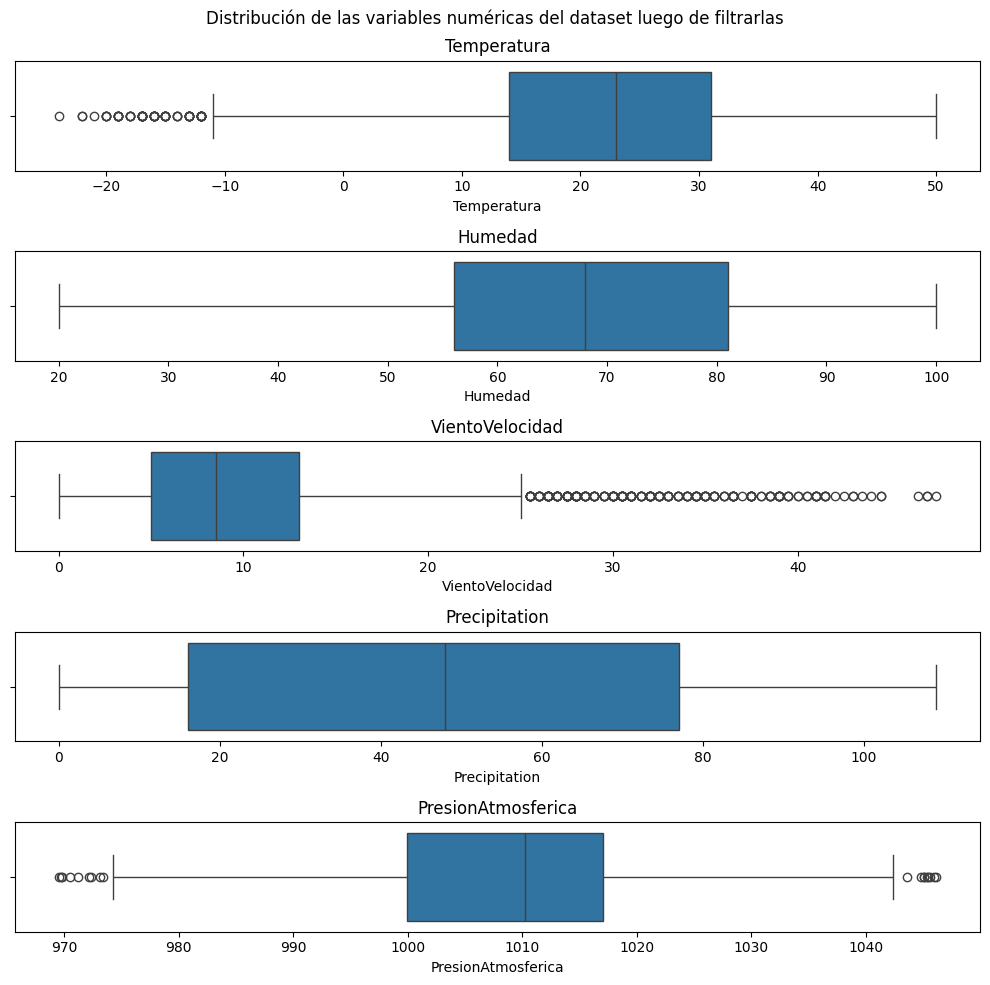

In [116]:
# Distribución de las variables numéricas luego de filtrarlas
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=df[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset luego de filtrarlas')
plt.tight_layout()
plt.show()

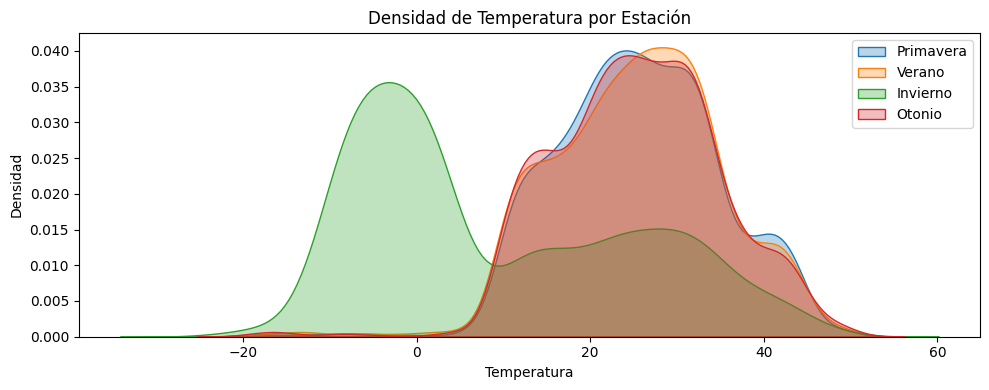

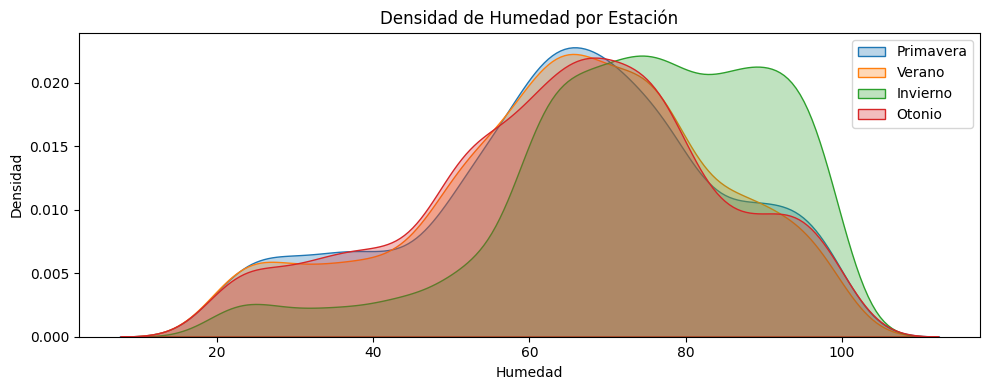

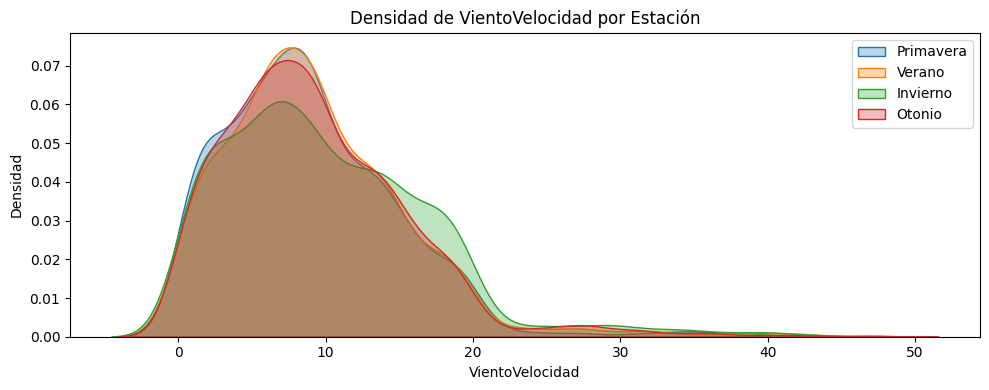

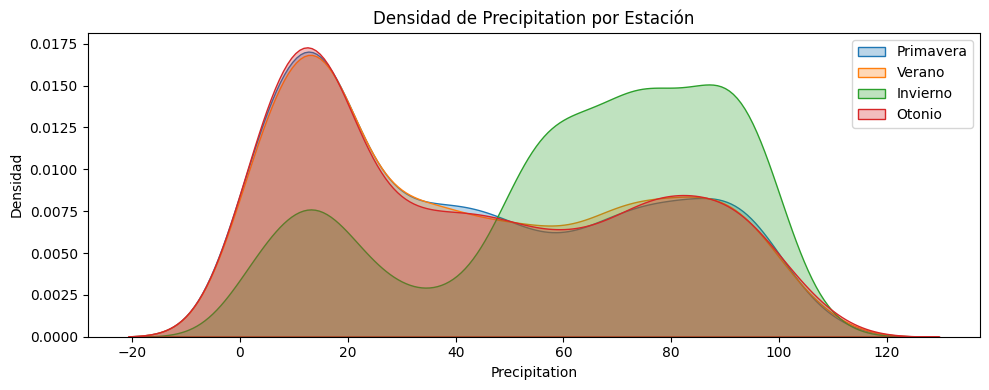

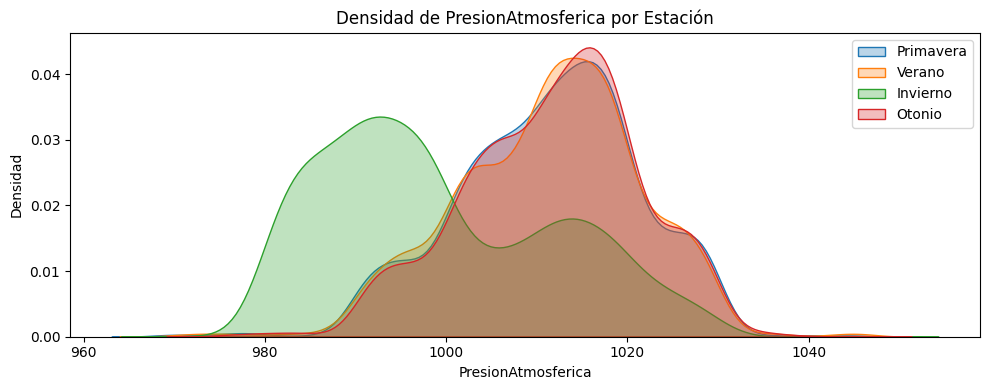

In [117]:
for col in columnas_numericas:
    plt.figure(figsize=(10, 4))
    for est in df['Estacion'].unique():
        sns.kdeplot(df[df['Estacion'] == est][col], label=est, fill=True, alpha=0.3)
    plt.title(f'Densidad de {col} por Estación')
    plt.xlabel(col)
    plt.ylabel("Densidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

**División test-train**

In [118]:
X = df.drop(columns=['Estacion'])
y = df['Estacion']

In [119]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# K-folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Guardamos los splits
splits = {}  

i = 1
for train_idx, test_idx in skf.split(X, y):
    splits[f"X_train{i}"] = X.iloc[train_idx]
    splits[f"y_train{i}"] = y.iloc[train_idx]
    splits[f"X_test{i}"]  = X.iloc[test_idx]
    splits[f"y_test{i}"]  = y.iloc[test_idx]
    i += 1


# Separamos los datasets en variables
X_train1 = splits['X_train1']
y_train1 = splits['y_train1']
X_test1 = splits['X_test1']
y_test1 = splits['y_test1']

X_train2 = splits['X_train2']
y_train2 = splits['y_train2']
X_test2 = splits['X_test2']
y_test2 = splits['y_test2']

X_train3 = splits['X_train3']
y_train3 = splits['y_train3']
X_test3 = splits['X_test3']
y_test3 = splits['y_test3']

X_train4 = splits['X_train4']
y_train4 = splits['y_train4']
X_test4 = splits['X_test4']
y_test4 = splits['y_test4']

X_train5 = splits['X_train5']
y_train5 = splits['y_train5']
X_test5 = splits['X_test5']
y_test5 = splits['y_test5']

## Máquinas de vectores: kernel linear

**Mejor modelo**

In [120]:
pipeline_base_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC())
])

In [121]:
# Ajuste de hiperparámetros
grilla_params_lineal = {
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_lineal = GridSearchCV(
    estimator=pipeline_base_svm,
    param_grid=grilla_params_lineal,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_lineal.fit(X_train1, y_train1)

y_pred_lineal = grid_search_lineal.predict(X_test1)

print(f"Mejor parámetro 'C' encontrado: {grid_search_lineal.best_params_}")
print(f"Mejor accuracy encontrado: {grid_search_lineal.best_score_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor parámetro 'C' encontrado: {'classifier__C': 0.1}
Mejor accuracy encontrado: 0.3877791662167096


**Métricas**

In [122]:
resultados = []

for i in range(1, 6):
    X_train = splits[f'X_train{i}']
    y_train = splits[f'y_train{i}']
    X_test  = splits[f'X_test{i}']
    y_test  = splits[f'y_test{i}']

    grid_search_lineal.fit(X_train, y_train)
    prediccion = grid_search_lineal.predict(X_test)

    resultados.append({
        'Fold': i,
        'Accuracy': accuracy_score(y_test, prediccion),
        'Precision': precision_score(y_test, prediccion, average='weighted'),
        'Recall': recall_score(y_test, prediccion, average='weighted'),
        'F1': f1_score(y_test, prediccion, average='weighted')
    })

df_resultados = pd.DataFrame(resultados)
df_resultados

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Fold,Accuracy,Precision,Recall,F1
0,1,0.413417,0.478471,0.413417,0.417602
1,2,0.380161,0.456126,0.380161,0.396568
2,3,0.386116,0.461803,0.386116,0.396575
3,4,0.389558,0.454785,0.389558,0.401325
4,5,0.396443,0.469947,0.396443,0.406391


In [123]:
resultados_lineal = {}
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']

for metrica in metricas:
    resultados_lineal[metrica] = df_resultados[metrica].mean()
        
resultados_lineal

{'Accuracy': np.float64(0.3931390042476591),
 'Precision': np.float64(0.4642264749084079),
 'Recall': np.float64(0.3931390042476591),
 'F1': np.float64(0.4036921261954112)}

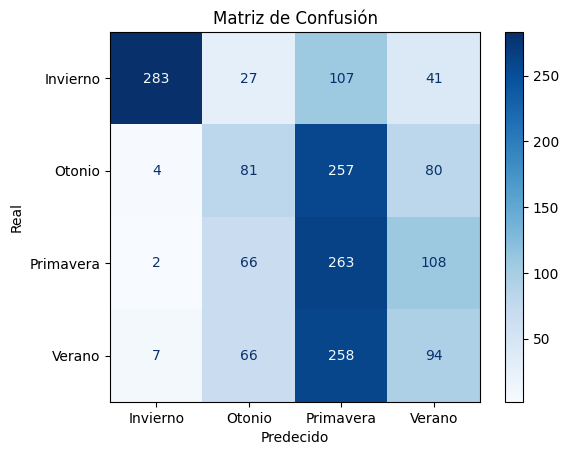

In [124]:
ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_lineal, cmap=plt.cm.Blues)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión');

## Máquinas de vectores: kernel gaussiano

In [125]:
pipeline_base_gauss = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

In [126]:
# Ajuste de hiperparámetros
grilla_params_gauss = {
    'classifier__kernel': ['rbf'],
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_gauss = GridSearchCV(
    estimator=pipeline_base_gauss,
    param_grid=grilla_params_gauss,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_gauss.fit(X_train1, y_train1)

y_pred_gauss = grid_search_gauss.predict(X_test1)

print(f"Mejor parámetro 'C' encontrado: {grid_search_gauss.best_params_}")
print(f"Mejor accuracy encontrado: {grid_search_gauss.best_score_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor parámetro 'C' encontrado: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
Mejor accuracy encontrado: 0.39337642636388415


**Metricas**

In [127]:
resultados_gauss = []

for i in range(1, 6):
    X_train = splits[f'X_train{i}']
    y_train = splits[f'y_train{i}']
    X_test  = splits[f'X_test{i}']
    y_test  = splits[f'y_test{i}']

    grid_search_gauss.fit(X_train, y_train)
    prediccion = grid_search_gauss.predict(X_test)

    resultados_gauss.append({
        'Fold': i,
        'Accuracy': accuracy_score(y_test, prediccion),
        'Precision': precision_score(y_test, prediccion, average='weighted'),
        'Recall': recall_score(y_test, prediccion, average='weighted'),
        'F1': f1_score(y_test, prediccion, average='weighted')
    })

df_resultados_gauss = pd.DataFrame(resultados_gauss)
df_resultados_gauss

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,Fold,Accuracy,Precision,Recall,F1
0,1,0.413417,0.480016,0.413417,0.430689
1,2,0.388188,0.467677,0.388188,0.409043
2,3,0.389558,0.475355,0.389558,0.406054
3,4,0.403328,0.479102,0.403328,0.345093
4,5,0.387263,0.453376,0.387263,0.407421


In [128]:
resultados_gauss = {}
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']

for metrica in metricas:
    resultados_gauss[metrica] = df_resultados_gauss[metrica].mean()

resultados_gauss

{'Accuracy': np.float64(0.39635093453762626),
 'Precision': np.float64(0.4711051654592895),
 'Recall': np.float64(0.39635093453762626),
 'F1': np.float64(0.39966032672075424)}

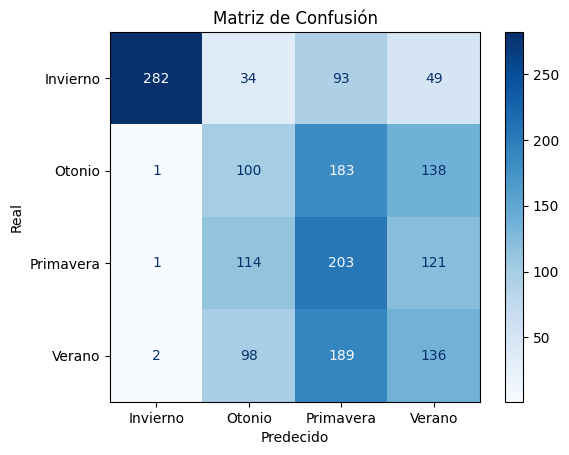

In [129]:
ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_gauss, cmap=plt.cm.Blues)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión');

## Random Forest

In [130]:
rf_base = RandomForestClassifier(random_state=42)

In [131]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, 30, None]
}

grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train1, y_train1)

y_pred_rf = grid_search_rf.predict(X_test1)

print("Mejores parámetros encontrados:")
print(grid_search_rf.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mejores parámetros encontrados:
{'max_depth': 5, 'n_estimators': 100}


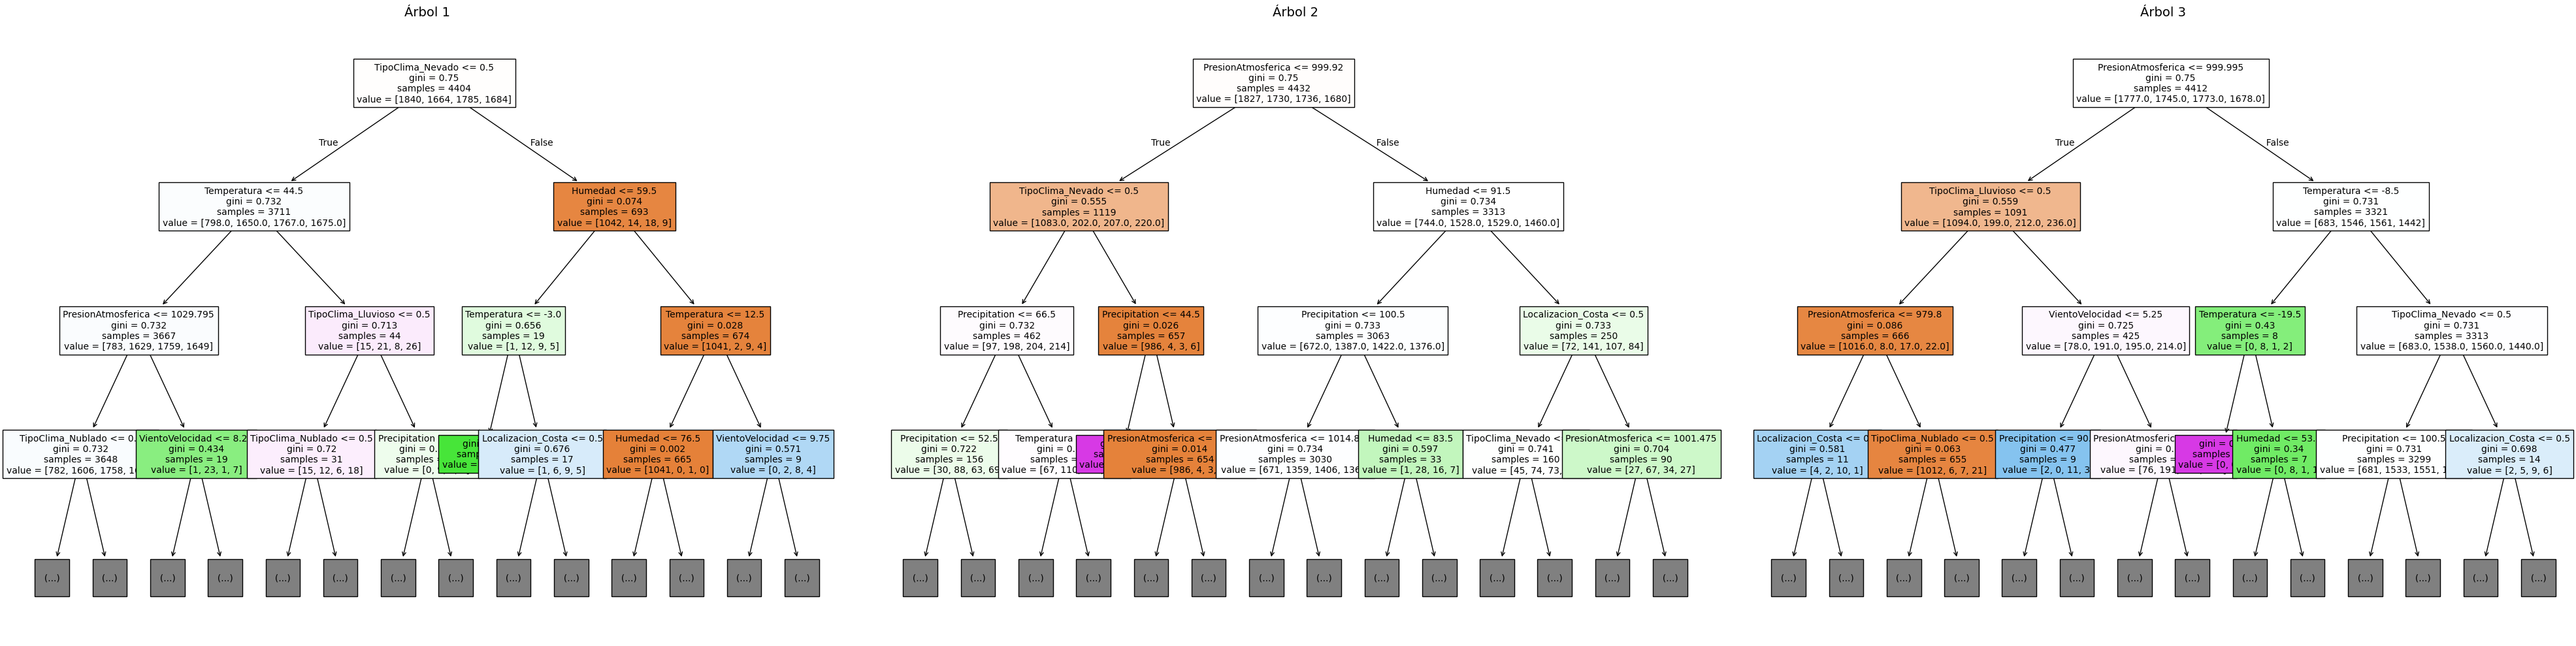

In [132]:
best_model = grid_search_rf.best_estimator_

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40, 10))

for i in range(3):
    plot_tree(
        best_model.estimators_[i],
        feature_names=X_train.columns,
        filled=True,
        max_depth=3,
        fontsize=10,
        ax=axes[i]
    )
    axes[i].set_title(f"Árbol {i+1}", fontsize=14)

plt.tight_layout()
plt.show()


**Métricas**

In [133]:
resultados_rf = []

for i in range(1, 6):
    X_train = splits[f'X_train{i}']
    y_train = splits[f'y_train{i}']
    X_test  = splits[f'X_test{i}']
    y_test  = splits[f'y_test{i}']

    grid_search_rf.fit(X_train, y_train)
    prediccion = grid_search_rf.predict(X_test)

    resultados_rf.append({
        'Fold': i,
        'Accuracy': accuracy_score(y_test, prediccion),
        'Precision': precision_score(y_test, prediccion, average='weighted'),
        'Recall': recall_score(y_test, prediccion, average='weighted'),
        'F1': f1_score(y_test, prediccion, average='weighted')
    })

df_resultados_rf = pd.DataFrame(resultados_rf)
df_resultados_rf

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits


,Fold,Accuracy,Precision,Recall,F1
0,1,0.418578,0.485962,0.418578,0.414184
1,2,0.375000,0.459706,0.375000,0.395266
2,3,0.375215,0.462280,0.375215,0.398652
3,4,0.374641,0.451038,0.374641,0.395992
4,5,0.388411,0.463043,0.388411,0.390689


In [134]:
resultados_rf = {}
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']

for metrica in metricas:
    resultados_rf[metrica] = df_resultados_rf[metrica].mean()

resultados_rf

{'Accuracy': np.float64(0.38636906735724025),
 'Precision': np.float64(0.46440601156842165),
 'Recall': np.float64(0.38636906735724025),
 'F1': np.float64(0.39895673390884867)}

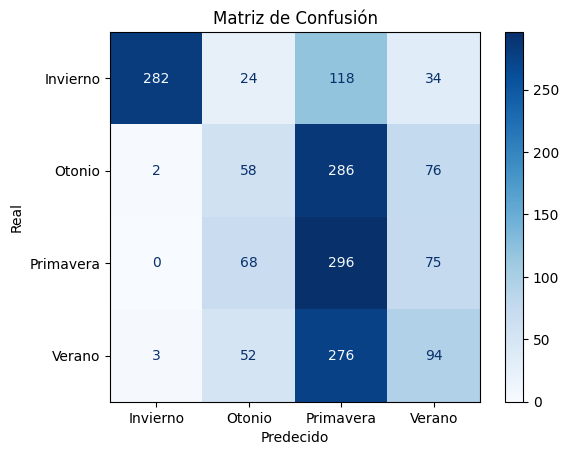

In [135]:
ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_rf, cmap=plt.cm.Blues)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión');

# Conclusión

In [136]:
resultados_metricas = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precisión', 'Recall', 'F1'],
    'Modelo rf': [resultados_rf['Accuracy'], resultados_rf['Precision'], resultados_rf['Recall'], resultados_rf['F1']],
    'Modelo gauss': [resultados_gauss['Accuracy'], resultados_gauss['Precision'], resultados_gauss['Recall'], resultados_gauss['F1']],
    'Modelo lineal': [resultados_lineal['Accuracy'], resultados_lineal['Precision'], resultados_lineal['Recall'], resultados_lineal['F1']]
})

resultados_metricas

,Métrica,Modelo rf,Modelo gauss,Modelo lineal
0,Accuracy,0.386369,0.396351,0.393139
1,Precisión,0.464406,0.471105,0.464226
2,Recall,0.386369,0.396351,0.393139
3,F1,0.398957,0.399660,0.403692


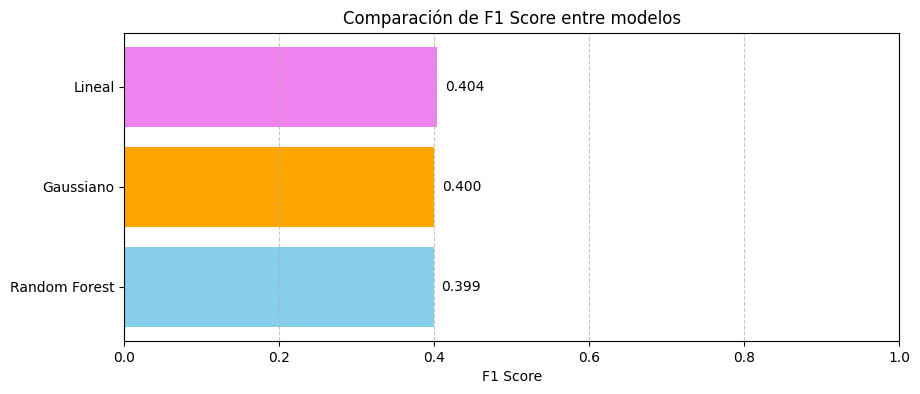

In [137]:
fila_f1 = resultados_metricas[resultados_metricas['Métrica'] == 'F1']

modelos = ['Random Forest', 'Gaussiano', 'Lineal']
scores = [
    fila_f1['Modelo rf'].values[0],
    fila_f1['Modelo gauss'].values[0],
    fila_f1['Modelo lineal'].values[0]
]

plt.figure(figsize=(10,4))
bars = plt.barh(modelos, scores, color=['skyblue', 'orange', 'violet'])
plt.xlim(0, 1)
plt.xlabel('F1 Score')
plt.title('Comparación de F1 Score entre modelos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width() + 0.01,bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center')

plt.show()

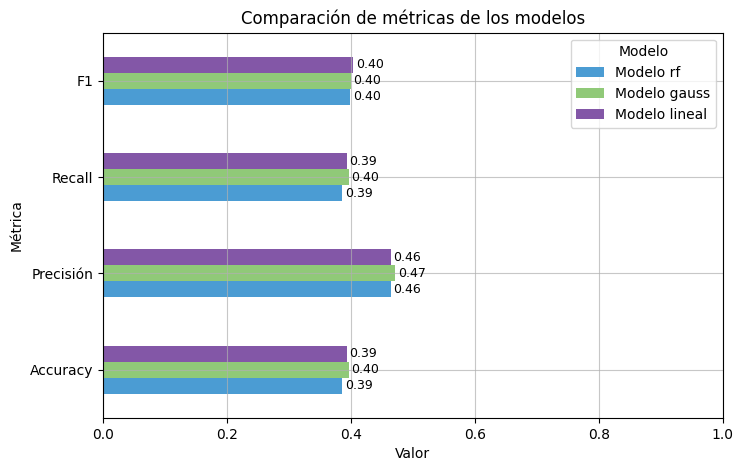

In [139]:
ax = resultados_metricas.plot(
    x='Métrica',
    kind='barh',
    figsize=(8,5),
    color=['#4B9CD3', '#90C978', "#8357A7"]
)

plt.title("Comparación de métricas de los modelos")
plt.xlabel("Valor")
plt.xlim(0, 1)
plt.legend(title="Modelo")
plt.grid(alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2, fontsize=9)

plt.show()

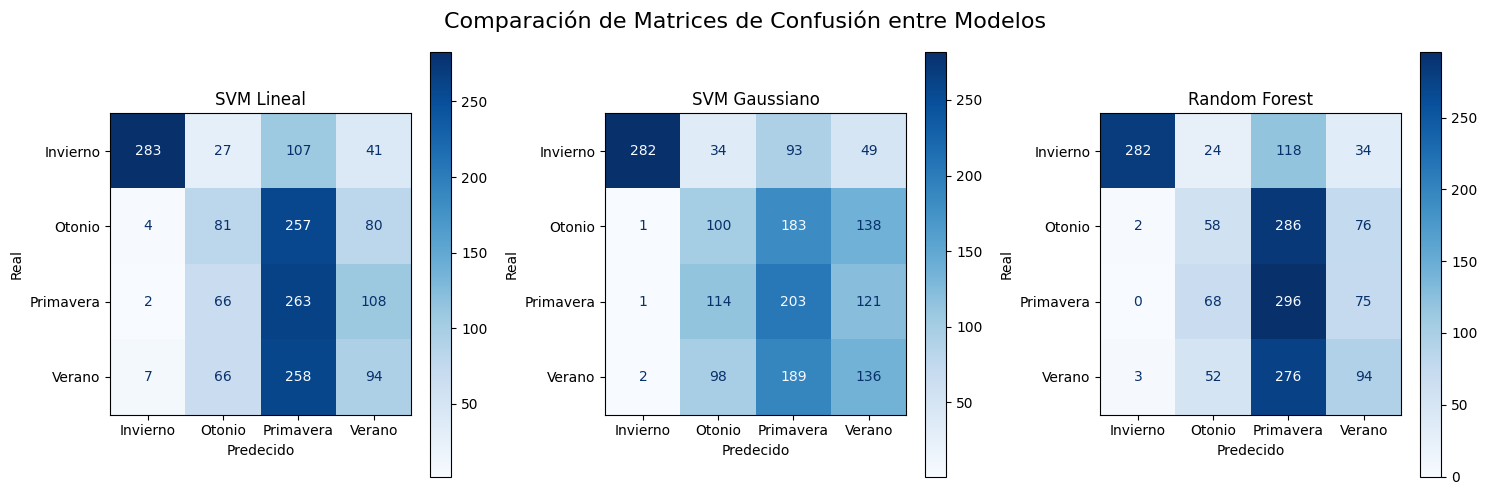

In [146]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Comparación de Matrices de Confusión entre Modelos", fontsize=16)
fig.subplots_adjust(top=0.85)

ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_lineal, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title("SVM Lineal")
axes[0].set_xlabel('Predecido')
axes[0].set_ylabel('Real')

ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_gauss, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title("SVM Gaussiano")
axes[1].set_xlabel('Predecido')
axes[1].set_ylabel('Real')

ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_rf, cmap=plt.cm.Blues, ax=axes[2])
axes[2].set_title("Random Forest")
axes[2].set_xlabel('Predecido')
axes[2].set_ylabel('Real')

plt.tight_layout()
plt.show()